# Define functions

In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import os
import json
import gc
from torch.distributions import Bernoulli
from torch.optim import LBFGS
from tqdm import tqdm
from scipy.stats import pearsonr
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Manager
import multiprocessing as mp

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tueplots import bundles
bundles.icml2024()

from torchmetrics import AUROC
auroc = AUROC(task="binary")

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(0)

device = "cuda:0"

def visualize_response_matrix(results, value, filename):
    # Extract the groups labels in the order of the columns
    group_values = results.columns.get_level_values("scenario")

    # Identify the boundaries where the group changes
    boundaries = []
    for i in range(1, len(group_values)):
        if group_values[i] != group_values[i - 1]:
            boundaries.append(i - 0.5)  # using 0.5 to place the line between columns

    # Visualize the results with a matrix: red is 0, white is -1 and blue is 1
    cmap = mcolors.ListedColormap(["white", "red", "blue"])
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Calculate midpoints for each group label
    groups_list = list(group_values)
    group_names = []
    group_midpoints = []
    current_group = groups_list[0]
    start_index = 0
    for i, grp in enumerate(groups_list):
        if grp != current_group:
            midpoint = (start_index + i - 1) / 2.0
            group_names.append(current_group)
            group_midpoints.append(midpoint)
            current_group = grp
            start_index = i
    # Add the last group
    midpoint = (start_index + len(groups_list) - 1) / 2.0
    group_names.append(current_group)
    group_midpoints.append(midpoint)

    # Define the minimum spacing between labels (e.g., 100 units)
    min_spacing = 100
    last_label_pos = -float("inf")
    # Plot the matrix
    with plt.rc_context(bundles.icml2024(usetex=True, family="serif")):
        fig, ax = plt.subplots(figsize=(20, 10))
        cax = ax.matshow(value, aspect="auto", cmap=cmap, norm=norm)

        # Add vertical lines at each boundary
        for b in boundaries:
            ax.axvline(x=b, color="black", linewidth=0.25, linestyle="--", alpha=0.5)
        
        # Add group labels above the matrix, only if they're spaced enough apart
        for name, pos in zip(group_names, group_midpoints):
            if pos - last_label_pos >= min_spacing:
                ax.text(pos, -5, name, ha='center', va='bottom', rotation=90, fontsize=3)
                last_label_pos = pos

        # Add model labels on the y-axis
        ax.set_yticks(range(len(results.index)))
        ax.set_yticklabels(results.index, fontsize=3)

        # Add a colorbar
        cbar = plt.colorbar(cax)
        cbar.set_ticks([-1, 0, 1])
        cbar.set_ticklabels(["-1", "0", "1"])
        plt.savefig(filename, dpi=600, bbox_inches="tight")
        plt.close()

def trainer(parameters, optim, closure, n_iter=100, verbose=True):
    pbar = tqdm(range(n_iter)) if verbose else range(n_iter)
    for iteration in pbar:
        if iteration > 0:
            previous_parameters = [p.clone() for p in parameters]
            previous_loss = loss.clone()
        
        loss = optim.step(closure)
        
        if iteration > 0:
            d_loss = (previous_loss - loss).item()
            d_parameters = sum(
                torch.norm(prev - curr, p=2).item()
                for prev, curr in zip(previous_parameters, parameters)
            )
            grad_norm = sum(torch.norm(p.grad, p=2).item() for p in parameters if p.grad is not None)
            if verbose:
                pbar.set_postfix({"grad_norm": grad_norm, "d_parameter": d_parameters, "d_loss": d_loss})
            
            if d_loss < 1e-5 and d_parameters < 1e-5 and grad_norm < 1e-5:
                break
    return parameters

def compute_auc(probs, data, train_idtor, test_idtor):
    train_probs = probs[train_idtor.bool()]
    test_probs = probs[test_idtor.bool()]
    train_labels = data[train_idtor.bool()]
    test_labels = data[test_idtor.bool()]
    
    train_auc = auroc(train_probs, train_labels)
    test_auc = auroc(test_probs, test_labels)
    print(f"train auc: {train_auc}")
    print(f"test auc: {test_auc}")
    
    return train_auc, test_auc

def compute_cttcorr(probs, data, train_idtor, test_idtor):
    train_probs  = probs.clone()
    test_probs   = probs.clone()
    train_labels = data.clone()
    test_labels  = data.clone()

    train_mask = ~train_idtor.bool()
    train_probs[train_mask]  = float('nan')
    train_labels[train_mask] = float('nan')

    test_mask = ~test_idtor.bool()
    test_probs[test_mask]   = float('nan')
    test_labels[test_mask]  = float('nan')
    
    train_prob_ctt = torch.nanmean(train_probs, dim=1).detach().cpu().numpy()
    train_label_ctt = torch.nanmean(train_labels, dim=1).detach().cpu().numpy()
    train_mask = ~np.isnan(train_prob_ctt) & ~np.isnan(train_label_ctt)
    train_cttcorr = pearsonr(train_prob_ctt[train_mask], train_label_ctt[train_mask]).statistic
    
    test_prob_ctt = torch.nanmean(test_probs, dim=1).detach().cpu().numpy()
    test_label_ctt = torch.nanmean(test_labels, dim=1).detach().cpu().numpy()
    test_mask = ~np.isnan(test_prob_ctt) & ~np.isnan(test_label_ctt)
    test_cttcorr = pearsonr(test_prob_ctt[test_mask], test_label_ctt[test_mask]).statistic
    
    print(f"train cttcorr: {train_cttcorr}")
    print(f"test cttcorr: {test_cttcorr}")

    return train_cttcorr, test_cttcorr

mkdir -p failed for path /dfs/user/sttruong/.cache/matplotlib: [Errno 13] Permission denied: '/dfs/user/sttruong'
Matplotlib created a temporary cache directory at /tmp/user/21130/matplotlib-2z_egxhn because there was an issue with the default path (/dfs/user/sttruong/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2025-06-05 05:39:37.471614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749127177.485482 2356811 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749127177.489712 2356811 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS 

# Load data

In [2]:
with open(f"../data/resmat.pkl", "rb") as f:
    results = pickle.load(f)
    
# data_withnan, missing=nan
# data_withneg1, missing=-1
# data_with0, missing=0
data_withnan = torch.tensor(results.values, dtype=torch.float, device=device)
data_withneg1 = data_withnan.nan_to_num(nan=-1.0)
data_idtor = (data_withneg1 != -1).to(float)
data_with0 = data_withneg1 * data_idtor # -1 -> 0
n_test_takers, n_items = data_with0.shape
scenarios = results.columns.get_level_values("scenario").unique()

# save dict
metric_results = defaultdict(dict)

# Data stats

In [3]:
vis_resmat_dir = "../result/visualize_resmat"
os.makedirs(vis_resmat_dir, exist_ok=True)

# overall stats
print("Number of test takers:", results.shape[0])
print("Number of items:", results.shape[1])
print("Number of scenarios:", results.columns.get_level_values("scenario").nunique())
visualize_response_matrix(results, results, f"{vis_resmat_dir}/resmat_all")

# count the number of items and test takers in each dataset
scenario_counts = {}
for scenario in sorted(scenarios):
    mask = results.columns.get_level_values("scenario") == scenario
    sub_results = results.loc[:, mask]
    scenario_counts[scenario] = {
        "n_items": sub_results.shape[1],
        "n_test_takers": sub_results.notna().any(axis=1).sum()
    }
    print(f"{scenario}: {scenario_counts[scenario]['n_test_takers']} test takers, {scenario_counts[scenario]['n_items']} items")
    # visualize_response_matrix(sub_results, sub_results, f"{vis_resmat_dir}/resmat_{scenario}")

Number of test takers: 183
Number of items: 78712
Number of scenarios: 22
air_bench_2024: 41 test takers, 4985 items
babi_qa: 70 test takers, 3461 items
bbq: 42 test takers, 999 items
boolq: 67 test takers, 3316 items
civil_comments: 67 test takers, 29407 items
commonsense: 91 test takers, 498 items
dyck_language_np=3: 69 test takers, 500 items
entity_data_imputation: 67 test takers, 395 items
entity_matching: 67 test takers, 1396 items
gsm: 90 test takers, 997 items
imdb: 67 test takers, 3530 items
legal_support: 69 test takers, 594 items
legalbench: 91 test takers, 1997 items
lsat_qa: 69 test takers, 454 items
math: 91 test takers, 436 items
med_qa: 91 test takers, 998 items
mmlu: 79 test takers, 13223 items
raft: 67 test takers, 1336 items
synthetic_reasoning: 69 test takers, 2234 items
thai_exam: 40 test takers, 557 items
truthful_qa: 67 test takers, 1888 items
wikifact: 67 test takers, 5511 items


# Naive prediction

In [64]:
# overall mean
naive_prediction_0 = torch.nanmean(data_withnan)
naive_prediction_0 = naive_prediction_0.expand(data_withnan.shape[0], data_withnan.shape[1])
auc_train_0 = auroc(naive_prediction_0[data_idtor.bool()], data_withnan[data_idtor.bool()]).item()
print(f"Naive auc 0: {auc_train_0}")

# question difficulty average
naive_prediction_1 = torch.nanmean(data_withnan, dim=0)
naive_prediction_1 = naive_prediction_1[None, :].expand(data_withnan.shape[0], data_withnan.shape[1])
auc_train_1_1 = auroc(naive_prediction_1[data_idtor.bool()], data_withnan[data_idtor.bool()]).item()
print(f"Naive auc 1.1: {auc_train_1_1}")

# test taker average
naive_prediction_1 = torch.nanmean(data_withnan, dim=1)
naive_prediction_1 = naive_prediction_1[:, None].expand(data_withnan.shape[0], data_withnan.shape[1])
auc_train_1_2 = auroc(naive_prediction_1[data_idtor.bool()], data_withnan[data_idtor.bool()]).item()
print(f"Naive auc 1.2: {auc_train_1_2}")

Naive auc 0: 0.5
Naive auc 1.1: 0.8070003986358643
Naive auc 1.2: 0.6573556065559387


# Simple Rasch model

fit one theat for all datasets

In [ ]:
# data_idtor = train_idtor + test_idtor
# apply random train/test mask to the matrix, and ensure no one row or column is fully masked
valid_condition = False
trial = 0
while not valid_condition:
    train_idtor = torch.bernoulli(data_idtor * 0.8).int()
    test_idtor = data_idtor - train_idtor
    valid_condition = (train_idtor.sum(axis=1) != 0).all() and (train_idtor.sum(axis=0) != 0).all()
    print(f"trial {trial} valid condition: {valid_condition}")
    trial += 1

# fit z
B = 50000
optimized_zs = []
thetas_nuisance = torch.randn(150, n_test_takers, device=device)
for i in tqdm(range(0, n_items, B)):
    data_batch = data_with0[:, i:i+B]
    train_idtor_batch = train_idtor[:, i:i+B]
    current_B = data_batch.shape[1]
    z_i = torch.randn(current_B, requires_grad=True, device=device)
    optim_z_i = LBFGS([z_i], lr=0.1, max_iter=20, history_size=10, line_search_fn="strong_wolfe")
    def closure_z_i():
        optim_z_i.zero_grad()
        probs = torch.sigmoid(thetas_nuisance[:, :, None] + z_i[None, None, :])
        loss = -(Bernoulli(probs=probs).log_prob(data_batch)*train_idtor_batch).mean()
        loss.backward()
        return loss
    z_i_optimized = trainer([z_i], optim_z_i, closure_z_i)[0].detach()
    optimized_zs.append(z_i_optimized)
zs = torch.cat(optimized_zs)

# fit theta
thetas = torch.randn(n_test_takers, requires_grad=True, device=device)
optim_theta = LBFGS([thetas], lr=0.1, max_iter=20, history_size=10, line_search_fn="strong_wolfe")
def closure_theta():
    optim_theta.zero_grad()
    probs = torch.sigmoid(thetas[:, None] + zs[None, :])
    loss = -(Bernoulli(probs=probs).log_prob(data_with0)*train_idtor).mean()
    loss.backward()
    return loss
thetas = trainer([thetas], optim_theta, closure_theta)[0]

# calculate metrics
probs = torch.sigmoid(thetas[:, None] + zs[None, :])

train_auc, test_auc = compute_auc(probs, data_with0, train_idtor, test_idtor)
metric_results["combined_data"]["train_auc"] = train_auc.item()
metric_results["combined_data"]["test_auc"] = test_auc.item()

train_cttcorr, test_cttcorr = compute_cttcorr(probs, data_with0, train_idtor, test_idtor)
metric_results["combined_data"]["train_cttcorr"] = train_cttcorr.item()
metric_results["combined_data"]["test_cttcorr"] = test_cttcorr.item()

del optim_theta, thetas, z_i, thetas_nuisance, optim_z_i
gc.collect()
torch.cuda.empty_cache()

  7%|▋         | 7/100 [00:00<00:06, 13.52it/s, grad_norm=1.99e-7, d_parameter=0, d_loss=6.58e-11]       


train auc: 0.8401544094085693
test auc: 0.8265177607536316
train cttcorr: 0.9999982965698357
test cttcorr: 0.9927450093359975


# Rasch

fit one theta for each dataset

In [ ]:
calres_dir = "../data/calibration_result"
os.makedirs(calres_dir, exist_ok=True)

for scenario in scenarios:
    print(f"\n{scenario}")
    mask = (results.columns.get_level_values("scenario") == scenario)
    data_scenario = data_with0[:, mask]
    train_idtor_scenario = train_idtor[:, mask]
    test_idtor_scenario = test_idtor[:, mask]
    z_scenario = zs[mask]
    df_z = pd.DataFrame({"z": z_scenario.detach().cpu().numpy()})
    df_z.to_csv(f'{calres_dir}/z_{scenario}.csv', index=False)

    thetas = torch.zeros(n_test_takers, requires_grad=True, device=device)
    optim_theta = torch.optim.LBFGS([thetas], lr=0.1, max_iter=20, history_size=10, line_search_fn="strong_wolfe")
    def closure_theta():
        optim_theta.zero_grad()
        probs = torch.sigmoid(thetas[:, None] + z_scenario[None, :])
        loss = -(Bernoulli(probs=probs).log_prob(data_scenario)*train_idtor_scenario).mean()
        loss.backward()
        return loss
    thetas = trainer([thetas], optim_theta, closure_theta, verbose=False)[0]
    df_theta = pd.DataFrame({"theta": thetas.detach().cpu().numpy()})
    df_theta = df_theta[df_theta["theta"] != 0]
    df_theta.to_csv(f'{calres_dir}/theta_{scenario}.csv', index=False)

    probs = torch.sigmoid(thetas[:, None] + z_scenario[None, :])
    train_auc, test_auc = compute_auc(probs, data_scenario, train_idtor_scenario, test_idtor_scenario)
    metric_results[scenario]["train_auc"] = train_auc.item()
    metric_results[scenario]["test_auc"] = test_auc.item()
    
    train_cttcorr, test_cttcorr = compute_cttcorr(probs, data_scenario, train_idtor_scenario, test_idtor_scenario)
    metric_results[scenario]["train_cttcorr"] = train_cttcorr.item()
    metric_results[scenario]["test_cttcorr"] = test_cttcorr.item()

del zs, optim_theta, thetas
gc.collect()
torch.cuda.empty_cache()


lsat_qa


train auc: 0.688523530960083
test auc: 0.6194833517074585
train cttcorr: 0.9999999954797291
test cttcorr: 0.5906119125422994

truthful_qa
train auc: 0.7754234075546265
test auc: 0.752168595790863
train cttcorr: 0.9999999890694462
test cttcorr: 0.9706165826374094

synthetic_reasoning
train auc: 0.8787771463394165
test auc: 0.8685898780822754
train cttcorr: 0.9999999995909886
test cttcorr: 0.9944507503020064

babi_qa
train auc: 0.8385953307151794
test auc: 0.825733482837677
train cttcorr: 0.9999999976074504
test cttcorr: 0.9801349393837014

wikifact
train auc: 0.8949015140533447
test auc: 0.8836542367935181
train cttcorr: 0.9999999986407333
test cttcorr: 0.9955563464912967

bbq
train auc: 0.7257800102233887
test auc: 0.6776220798492432
train cttcorr: 0.9999999872610216
test cttcorr: 0.9853548320237024

thai_exam
train auc: 0.857973575592041
test auc: 0.8284746408462524
train cttcorr: 0.9999999915025175
test cttcorr: 0.9473795683343597

dyck_language_np=3
train auc: 0.7987954020500183
tes

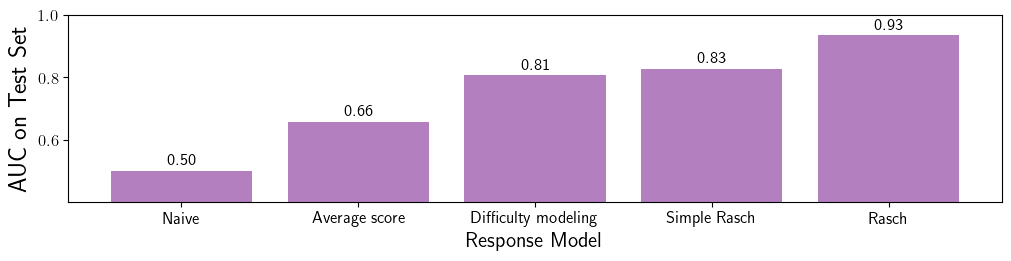

In [84]:
values = [
    auc_train_0, auc_train_1_2, auc_train_1_1, 
    metric_results["combined_data"]["test_auc"],
    np.max(np.array([metric_results[scenario]["test_auc"] for scenario in scenarios]))
]
labels = ['Naive', 'Average score', 'Difficulty modeling', 'Simple Rasch', 'Rasch']

with plt.rc_context(bundles.icml2024(usetex=True, family="serif")):
    fig, ax = plt.subplots(figsize=(10, 2.5))
    bars = ax.bar(labels, values, color='#b37fbf')

    ax.set_xlabel(r'Response Model', fontsize=15)
    ax.set_ylabel(r'AUC on Test Set', fontsize=18)
    ax.set_ylim(0.4, 1.0)
    ax.set_yticks([i/5 for i in range(3, 6)])
    plt.tick_params(axis="both", labelsize=12)

    for bar, v in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, v + 0.01, f'{v:.2f}', 
                ha='center', va='bottom', fontsize=12)
    
    plt.savefig("../result/test_auc_grow.png", dpi=300, bbox_inches="tight")
plt.show()

# Amortized Difficulty

In [ ]:
with open(f"../data/embed_meta-llama_Llama-3.1-8B-Instruct.pkl", "rb") as f:
    df_embed = pickle.load(f)
question_to_emb = dict(zip(df_embed["question"], df_embed["embedding"]))
questions = results.columns.get_level_values("input.text").tolist()
embeds = [question_to_emb.get(q, None) for q in questions]
embed_dim = len(next(item for item in embeds if item is not None))
print(f"embed_dim: {embed_dim}")

Fraction of questions with feature:  0.9996951222419739


In [40]:
all_scenarios = results.columns.get_level_values("scenario").unique().tolist() + ["combined_data"]
for scenario in all_scenarios:
    print(f"\n{scenario}")
    
    if scenario != "combined_data":
        mask = (results.columns.get_level_values("scenario") == scenario)
        data_scenario = data_with0[:, mask]
        data_idtor_scenario = data_idtor[:, mask]
        embeds_scenario = [emb for emb, m in zip(embeds, mask) if m]
    else:
        data_scenario = data_with0
        data_idtor_scenario = data_idtor
        test_idtor_scenario = test_idtor
        embeds_scenario = embeds
    n_items_scenario = data_scenario.shape[1]
    
    has_feature = [0.0 if item is None else 1.0 for item in embeds_scenario]
    has_feature = torch.tensor(has_feature, dtype=torch.float, device=device)
    has_feature_train = torch.bernoulli(has_feature * 0.8).int()
    has_feature_test = (has_feature - has_feature_train).int()

    features = [[0] * embed_dim if i is None else i for i in embeds_scenario]
    features = torch.tensor(features, dtype=torch.float, device=device)
    train_idtor_scenario = has_feature_train[None, :].repeat(n_test_takers, 1) * data_idtor_scenario
    test_idtor_scenario = has_feature_test[None, :].repeat(n_test_takers, 1) * data_idtor_scenario
    
    B = 50000
    thetas_nuisance = torch.randn(150, n_test_takers, device=device)
    w = torch.randn(embed_dim, requires_grad=True, device=device)
    b = torch.randn(1, requires_grad=True, device=device)
    z_free = torch.zeros(n_items_scenario, requires_grad=True, device=device)
    optim_z = LBFGS([z_free, w, b], lr=0.1, max_iter=20, history_size=10, line_search_fn="strong_wolfe")
    
    def closure_z():
        idx = torch.randperm(n_items_scenario)[:B]
        data_batch = data_scenario[:, idx]
        train_idtor_batch = train_idtor_scenario[:, idx]
        features_batch = features[idx]
        has_feature_train_batch = has_feature_train[idx]
        z_free_batch = z_free[idx]
        
        optim_z.zero_grad()
        z = z_free_batch * (1 - has_feature_train_batch) + (features_batch@w + b) * has_feature_train_batch
        probs = torch.sigmoid(thetas_nuisance[:, :, None] + z[None, None, :])
        loss = -(Bernoulli(probs=probs).log_prob(data_batch)*train_idtor_batch).mean()
        loss.backward()
        return loss
    
    z_free, w, b = trainer([z_free, w, b], optim_z, closure_z)
    z = z_free * (1 - has_feature) + (features@w + b) * has_feature
    z = z.detach()

    thetas = torch.randn(n_test_takers, requires_grad=True, device=device)
    optim_theta = LBFGS([thetas], lr=0.1, max_iter=20, history_size=10, line_search_fn="strong_wolfe")
    def closure_theta():
        optim_theta.zero_grad()
        probs = torch.sigmoid(thetas[:, None] + z[None, :])
        loss = -(Bernoulli(probs=probs).log_prob(data_scenario)*train_idtor_scenario).mean()
        loss.backward()
        return loss
    thetas = trainer([thetas], optim_theta, closure_theta)[0]

    probs = torch.sigmoid(thetas[:, None] + z[None, :])
    
    train_auc, test_auc = compute_auc(probs, data_scenario, train_idtor_scenario, test_idtor_scenario)
    metric_results[scenario]["amortized_train_auc"] = train_auc.item()
    metric_results[scenario]["amortized_test_auc"] = test_auc.item()

    train_cttcorr, test_cttcorr = compute_cttcorr(probs, data_scenario, train_idtor_scenario, test_idtor_scenario)
    metric_results[scenario]["amortized_train_cttcorr"] = train_cttcorr.item()
    metric_results[scenario]["amortized_test_cttcorr"] = test_cttcorr.item()
    
    gc.collect()
    torch.cuda.empty_cache()


entity_data_imputation


  1%|          | 1/100 [00:00<00:11,  8.61it/s]

 12%|█▏        | 12/100 [00:00<00:01, 70.27it/s, grad_norm=1.79e-7, d_parameter=0, d_loss=-2.19e-10]     


train auc: 0.9439506530761719
test auc: 0.9180223941802979
train cttcorr: 0.9999999993333711
test cttcorr: 0.967654010929555

commonsense


 12%|█▏        | 12/100 [00:00<00:01, 84.41it/s, grad_norm=4.53e-7, d_parameter=0, d_loss=1.63e-10]       


train auc: 0.9292876720428467
test auc: 0.7974473237991333
train cttcorr: 0.9999999980032216
test cttcorr: 0.9836946543690086

imdb


 11%|█         | 11/100 [00:00<00:00, 102.93it/s, grad_norm=2.55e-7, d_parameter=0, d_loss=7.82e-11]       


train auc: 0.925557017326355
test auc: 0.8450058102607727
train cttcorr: 0.9999999871288912
test cttcorr: 0.9919793604970778

combined_data


 15%|█▌        | 15/100 [00:00<00:03, 23.44it/s, grad_norm=2.47e-7, d_parameter=0, d_loss=1.06e-10]      


train auc: 0.7399625778198242
test auc: 0.7375156879425049
train cttcorr: 0.9999987607753383
test cttcorr: 0.9958644083237587


In [43]:
with open(f'../result/calibration_metric_results.json', 'w') as f:
    json.dump(metric_results, f, indent=4)

In [93]:
def plot_corr_double(
    data1_train,
    data1_test,
    data2_train,
    data2_test,
    plot_path,
    metric_name,
):
    with plt.rc_context(bundles.icml2024(usetex=True, family="serif")):
        corr_train = pearsonr(data1_train, data2_train).statistic
        corr_test  = pearsonr(data1_test,  data2_test ).statistic

        plt.figure(figsize=(6, 6))
        plt.scatter(data1_train, data2_train, color="blue", label="Train")
        plt.scatter(data1_test,  data2_test, color="red",  label="Test")
        plt.plot([0, 1], [0, 1], linestyle="--", color="black")

        plt.xlabel(r"Amortized Calibration", fontsize=25)
        plt.ylabel(r"Traditional Calibration", fontsize=25)
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        title = (
            rf"{metric_name}. "
            rf"$\rho_{{train}}$ = {corr_train:.2f}, "
            rf"$\rho_{{test}}$ = {corr_test:.2f}"
        )
        plt.title(title, fontsize=25)

        plt.tick_params(axis="both", labelsize=16)
        plt.legend(fontsize=16)
        plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    
with open("../result/calibration_metric_results.json", "r") as f:
    metric_results = json.load(f)

train_aucs = []
test_aucs = []
amor_train_aucs = []
amor_test_aucs = []
for scenario in metric_results:
    train_aucs.append(metric_results[scenario]["train_auc"])
    test_aucs.append(metric_results[scenario]["test_auc"])
    amor_train_aucs.append(metric_results[scenario]["amortized_train_auc"])
    amor_test_aucs.append(metric_results[scenario]["amortized_test_auc"])
plot_corr_double(amor_train_aucs, amor_test_aucs, train_aucs, test_aucs, "../result/amor_vs_trad_auc.png", r"AUC-ROC")

train_cttcorrs = []
test_cttcorrs = []
amor_train_cttcorrs = []
amor_test_cttcorrs = []
for scenario in metric_results:
    train_cttcorrs.append(metric_results[scenario]["train_cttcorr"])
    test_cttcorrs.append(metric_results[scenario]["test_cttcorr"])
    amor_train_cttcorrs.append(metric_results[scenario]["amortized_train_cttcorr"])
    amor_test_cttcorrs.append(metric_results[scenario]["amortized_test_cttcorr"])
plot_corr_double(amor_train_cttcorrs, amor_test_cttcorrs, train_cttcorrs, test_cttcorrs, "../result/amor_vs_trad_cttcorr.png", r"$\theta$ Corr Avg")

# Amortize Ability